In [6]:
import numpy as np
import pickle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [52]:
def get_imdb_data(movie_name):
    #find good way to soup this data from IMDB
    url = 'http://www.imdb.com' + str(movie_df.loc[movie_name, 'IMDBurl'])
    page = requests.get(url).text
    soup = BeautifulSoup(page, 'html5lib')
    
    try: # to get Ratings data
        movie_df.loc[movie_name, 'UserRating'] = float(soup.find(itemprop="ratingValue").text)/10
        movie_df.loc[movie_name, 'MetaRating'] = float(soup.find(class_="star-box-details").find_all('a')[1].text[:3])/100
    except:
        pass
    
    try: # to get Runtime, Year, Earnings
        movie_df.loc[movie_name, 'Runtime'] = int(soup.find(itemprop="duration").text.split(' ')[16])
        movie_df.loc[movie_name, 'Year'] = soup.find(class_="nobr").text.replace('(', '').replace(')', '')
        movie_df.loc[movie_name, 'BoxOfficeGross'] = money_to_int(soup.find_all(class_='txt-block')[14].text)
        movie_df.loc[movie_name, 'OpeningWeekend'] = money_to_int(soup.find_all(class_='txt-block')[13].text)
    except:
        pass
    
    try: # to get Awards & Budget data
        if soup.find_all(itemprop="awards")[0].find('b').text.split(' ')[0] == 'Won':
            movie_df.loc[movie_name, 'AwardsWon'] = \
                        int(soup.find_all(itemprop="awards")[0].find('b').text.split(' ')[1])
        else:
            movie_df.loc[movie_name, 'AwardsNominated'] = \
                        int(soup.find_all(itemprop="awards")[0].find('b').text.split(' ')[2])
        movie_df.loc[movie_name, 'Budget'] = money_to_int(soup.find_all(class_='txt-block')[12].text)*100000
    except:
        pass

In [ ]:
movie_df = pd.DataFrame(index=titles.keys(), columns=['IMDBurl', 'AwardsWon', 'AwardsNominated', 'MetaRating', 'UserRating', 
                                                      'Runtime', 'Year','BoxOfficeGross', 'OpeningWeekend', 'Budget'])
movie_df = movie_df.fillna(0) # with 0s rather than NaNs
#movie_df['Title'] = titles
for i in movie_df.index:
    movie_df.loc[i, 'IMDBurl'] = titles[i]

In [7]:
with open("movies.pkl", 'r') as picklefile: 
    df = pickle.load(picklefile)

In [8]:
rated = df[df['MetaRating'] > 0.10]
financed = rated[rated['BoxOfficeGross'] > 10000] # anything less than 10,000 is a: sad, b: probably a parse error
winners = financed[financed['AwardsWon'] > 0]
nominees = financed[financed['AwardsNominated'] > 0]
total = financed
total['AwardRank'] = total['AwardsWon'] + total['AwardsNominated']

/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


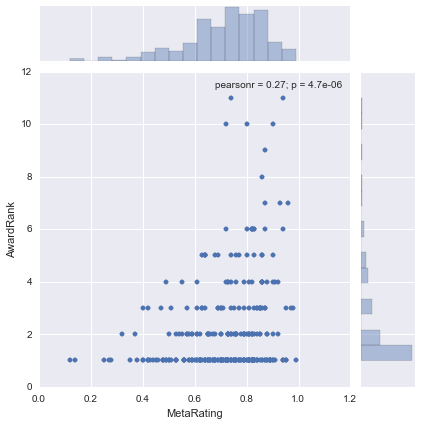

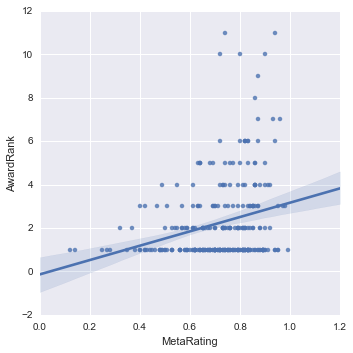

In [17]:
%matplotlib inline
sns.jointplot(x="MetaRating", y="AwardRank", data=total)
sns.lmplot(x="MetaRating", y="AwardRank", data=total)

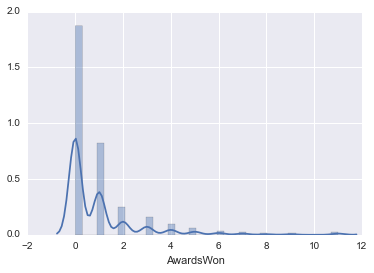

In [75]:
sns.distplot(total['AwardsWon'])

$y = \beta_0 + \beta_1 e^{X_1} + \beta_2 e^{X_2} +\beta_3 X_3 + \beta_4 X_4 + ...$

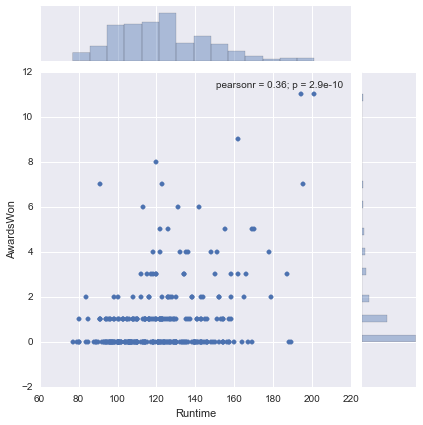

In [26]:
y = total['AwardsWon'].as_matrix().tolist()
x1 = [1 for _ in y] # constant
x2 = total['OpeningWeekend'].as_matrix().tolist()
X = pd.DataFrame(data={'Intercept': x1, 'Slope': x2})
model = sm.OLS(y, X)
results = model.fit()
results.summary()
sns.jointplot(x="Runtime", y="AwardsWon", data=total)